Upload content image:


Saving effiltower.jpg to effiltower.jpg
Saving van gogh starry night.jpg to van gogh starry night.jpg
Upload style image:


Saving effiltower.jpg to effiltower (1).jpg
Saving van gogh starry night.jpg to van gogh starry night (1).jpg
Epoch 50, Total Loss: 0.0000
Epoch 100, Total Loss: 0.0000
Epoch 150, Total Loss: 0.0000
Epoch 200, Total Loss: 0.0000
Epoch 250, Total Loss: 0.0000
Epoch 300, Total Loss: 0.0000


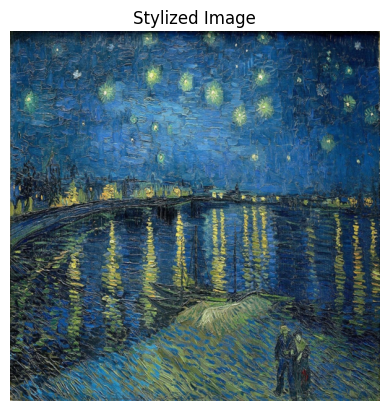

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformation
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),  # remove alpha channel if exists
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(uploaded_file):
    image = Image.open(uploaded_file)
    image = transform(image).unsqueeze(0).to(device)
    return image

# Upload images
print("Upload content image:")
content_img = load_image(files.upload().popitem()[0])

print("Upload style image:")
style_img = load_image(files.upload().popitem()[0])

# Load pre-trained VGG19
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Freeze VGG parameters
for param in vgg.parameters():
    param.requires_grad = False

# Define feature extraction layers
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',  # content layer
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[name] = x
    return features

# Gram matrix for style
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())

# Extract features
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Initialize target as a clone of content image
target = content_img.clone().requires_grad_(True).to(device)

# Weights for style layers
style_weights = {
    '0': 1.0,
    '5': 0.75,
    '10': 0.5,
    '19': 0.25,
    '28': 0.1
}

# Loss and optimizer
content_weight = 1e4
style_weight = 1e2
optimizer = optim.Adam([target], lr=0.003)

# Training loop
epochs = 300
for i in range(1, epochs + 1):
    target_features = get_features(target, vgg)

    # Content loss
    content_loss = torch.mean((target_features['21'] - content_features['21']) ** 2)

    # Style loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_loss / (target_feature.shape[1] ** 2)

    # Total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print(f"Epoch {i}, Total Loss: {total_loss.item():.4f}")

# Convert tensor to image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    image = image.clamp(0, 1)
    return transforms.ToPILImage()(image)

# Show result
plt.imshow(im_convert(target))
plt.axis("off")
plt.title("Stylized Image")
plt.show()
